# Simple notebook analysis. Fill the variables in cell 1, then run all cells.

Note: The following edge cases are known and not handled automatically:
1) Shenandoah has two phases reporting Heap allocation: Does not imply twice the GC runs.
2) ZGC in JDK16 Puts information in safepoints, does not AUTOMATICALLY print these in log analysis as it currently stands
3) ZGC bytes reclaimed calculation (This may extend to Shenandoah) may be negative, if the rate of allocation exceeds the rate of gc collection. Information is correctly provided in logs, not properly analyzed here yet
4) Trying to plot a graph declared in another cell does not show up inline in Jupyter notebooks
5) Using column_timing = "DateTime" in any function that requires as an "interval_duration" breaks the tool


In [174]:
# Fill in the following variables then run all cells

filepaths = ["/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+par/gc.log*", 
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+cms/gc.log",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk11+g1/gc.log*",
             "/Users/ellisbrown/Desktop/Project/cassandra-data/workloads/jdk16+shen/gc.log*"] # note the wildcards
labels = ["jdk11 Par", "jdk11 cms", "jdk11 G1", "jdk16 Shen"]

# filepaths = ["/Users/ellisbrown/Desktop/Project/datasets/hbase-regionserver-gc-ps1593-32577.log"]
# labels = ["run1 (ps1593-32577)"]
time_range_seconds = None
# set_start_times_zero = [True]
set_start_times_zero = None

csv_files_to_import = []
csv_file_labels = []

# Used for development
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
files = []
import sys
sys.path.append("../../") 
sys.path.append("../") 
import os.path
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 7] #  Size of figures created from plots by default [12,7]
from src.read_log_file import get_gc_event_tables, get_file_names_wildcard, zero_start_times
# Get all files
for filepath in filepaths:
    files.append(get_file_names_wildcard(filepath))
# Parse all files

gc_event_dataframes = get_gc_event_tables(files, time_range_seconds,  ignore_crashes=False)
# Import CSV files
for csv_file, label in zip(csv_files_to_import, csv_file_labels):
    if os.path.isfile(csv_file):
        df = pd.read_csv(csv_file)
        gc_event_dataframes.append(df)
        labels.append(label)
    else:
        print("Error: Unable to find file " + csv_file)

# Check that there are the correct number of labels.
if len(gc_event_dataframes) != len(labels):
    print("Error: Labels do not have same length as collected data")


if set_start_times_zero:
    zero_start_times(gc_event_dataframes, set_start_times_zero)

## Compare STW pauses during runtime

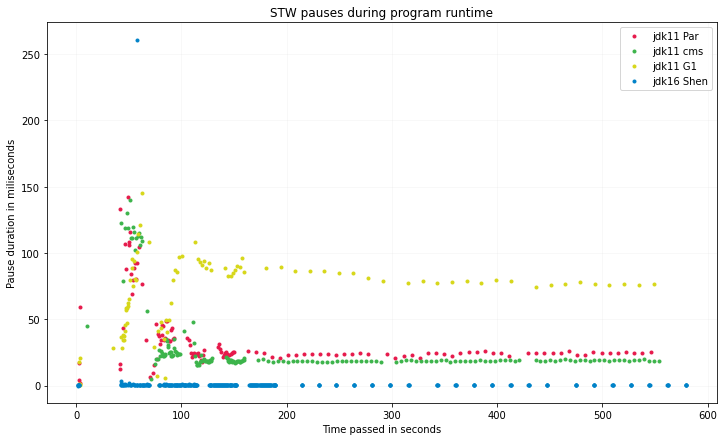

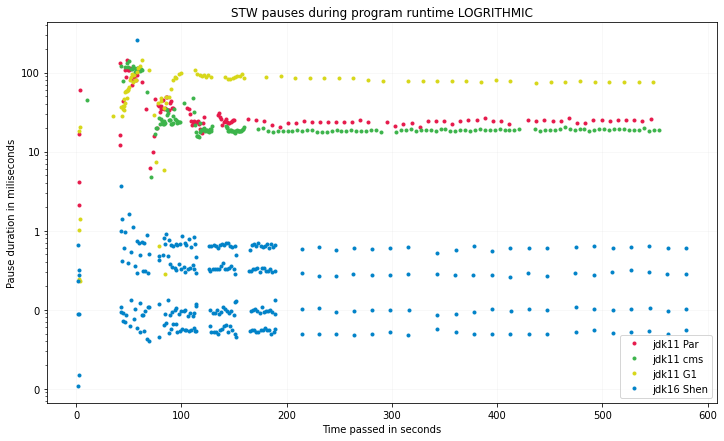

In [176]:
from src.graphing.plotting import plot_scatter

# Define a filter for searching for pauses in a gc_event_dataframe row
def pauses_only(row):
    if "EventType" in row:
        if row["EventType"] == "Pause":
            return True
    return False 

# Apply the filter, and create a plot
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels)

# Set the style and details on the plot
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

############################################################################################################
# Chart #2, logarithmic Y axis

plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels)

_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

# Set logarithmic scale 
from matplotlib.ticker import ScalarFormatter
plot.set_yscale("log") 
for axis in [plot.xaxis, plot.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

## Pauses by name during runtime

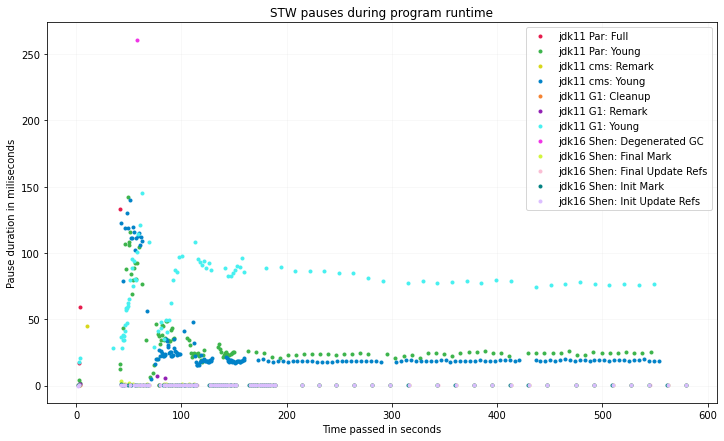

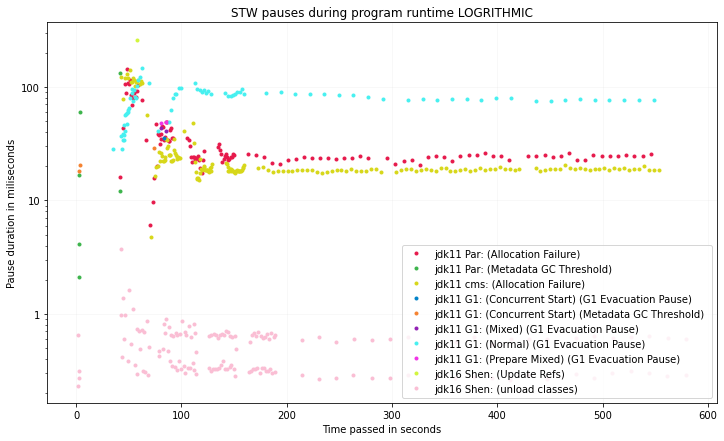

In [177]:
from src.graphing.plotting import plot_scatter
# Chart #1, linear Y axis
plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels=labels, group_by = "EventName")
_ = plot.set_title("STW pauses during program runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

############################################################################################################

# Chart #2, logarithmic Y axis

plot = plot_scatter(gc_event_dataframes, filter_by = pauses_only, labels = labels, group_by = "AdditionalEventInfo")
_ = plot.set_title("STW pauses during program runtime LOGRITHMIC")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Pause duration in miliseconds")
plot.grid(alpha = 0.1)

# Set log scale
from matplotlib.ticker import ScalarFormatter
plot.set_yscale("log") 
for axis in [plot.xaxis, plot.yaxis]:
    axis.set_major_formatter(ScalarFormatter())

## Concurrent durations during runtime

'Logarithmic graph : Uncomment to view'

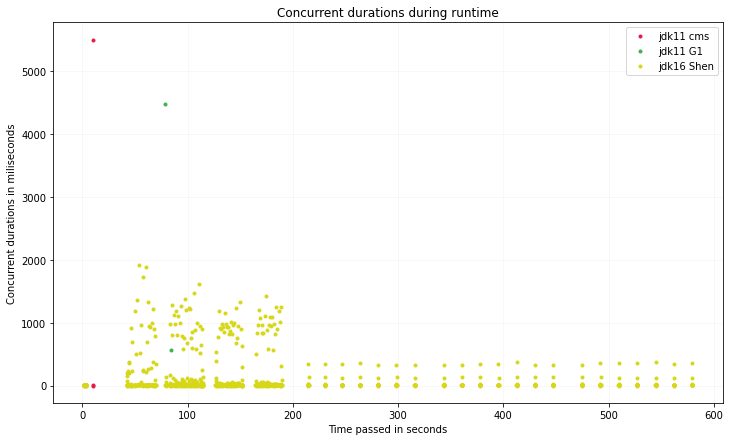

In [178]:
from src.graphing.plotting import plot_scatter

def concurrent_only(row):
    if "EventType" in row:
        if row["EventType"] == "Concurrent":
            return True
    return False

# Linear Graph
plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
_ = plot.set_title("Concurrent durations during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Concurrent durations in miliseconds")
plot.grid(alpha = 0.1)

'''Logarithmic graph : Uncomment to view'''
# plot = plot_scatter(gc_event_dataframes, labels=labels, filter_by= concurrent_only)
# _ = plot.set_title("Concurrent durations during runtime LOGRITHMIC")
# plot.set_xlabel("Time passed in seconds")
# plot.set_ylabel("Concurrent durations in miliseconds")
# plot.grid(alpha = 0.1)

# # Set log scale
# from matplotlib.ticker import ScalarFormatter
# plot.set_yscale("log") 
# for axis in [plot.xaxis, plot.yaxis]:
#     axis.set_major_formatter(ScalarFormatter())

## Time spent in STW vs. Concurrent

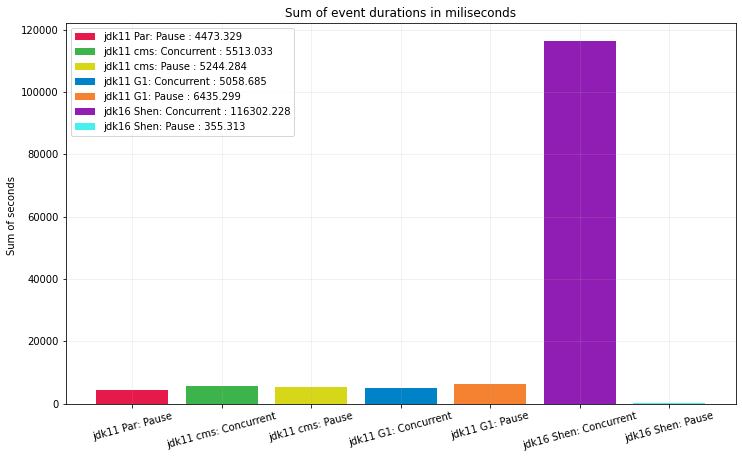

In [179]:
from src.graphing.plotting import plot_bar_sum

log = False # Set to True to view log bar graph as well
def duration_present(row):
    if "Duration_miliseconds" in row:
        if row["Duration_miliseconds"]:
            return True
    return False
# The grouping by eventtype means that every matching event name lives in one group. 
# Example: "Concurrent" events are a group, and "Pause" events are a group
plot = plot_bar_sum(gc_event_dataframes, group_by = "EventType", filter_by = duration_present, labels= labels)
_ = plot.set_title("Sum of event durations in miliseconds")
_ = plot.set_ylabel("Sum of seconds ")
_ = plt.xticks(rotation = 15)
plot.grid(alpha = 0.2)



## Comparing Trends within the data

In [180]:
from src.graphing.plotting import plot_trends
print("\t\t\tPauses during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels,
       throughput=True)
print("\n\n\t\t\tPauses by name during runtime\n------------------------------------------------------------------------------------------------------------------")
plot_trends(gc_event_dataframes, 
       group_by = "EventName",
       filter_by = pauses_only,
       labels= labels)


			Pauses during runtime
------------------------------------------------------------------------------------------------------------------
  Trends (ms)   | Event Count   | Max Duration  | Sum Duration  | Mean Duration | Std Dev.      | Throughput    |
-----------------------------------------------------------------------------------------------------------------
jdk11 Par       |  126.0000     |  142.3160     | 4473.3290     |   35.5026     |   26.1313     |   99.1800     % 
jdk11 cms       |  178.0000     |  139.9610     | 5244.2840     |   29.4623     |   28.1834     |   99.0500     % 
jdk11 G1        |   95.0000     |  145.4760     | 6435.2990     |   67.7400     |   30.3833     |   94.7100     % 
jdk16 Shen      |  312.0000     |  260.9410     |  355.3130     |    1.1388     |   14.7357     |   99.9400     % 


			Pauses by name during runtime
------------------------------------------------------------------------------------------------------------------
Legend: 
A | jdk11 Par

## Percentiles of event durations

In [181]:
from src.graphing.plotting import plot_percentiles

print("\t\t\tPause percentiles during runtime\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       filter_by = pauses_only,
       labels= labels)
print("\n\n\t\t\tPause percentiles during runtime by name\n----------------------------------------------------------------------------------")
plot_percentiles(gc_event_dataframes, 
       group_by = "EventName",
       filter_by= pauses_only,
       labels= labels)
       

			Pause percentiles during runtime
----------------------------------------------------------------------------------
Legend (All timing in miliseconds) : 
A | jdk11 Par
B | jdk11 cms
C | jdk11 G1
D | jdk16 Shen
-------------------------------------------------------------------------------------------------
    | 50%       | 75%       | 90%       | 95%       | 99%       | 99.9%     | 99.99%    | 
------------------------------------------------------------------------------------------------
A   |   24.7390 |   35.1915 |   79.9320 |  101.5342 |  128.7265 |  141.1636 |  142.2008 | 
B   |   18.9335 |   22.6820 |   50.4192 |  112.0748 |  124.2307 |  138.2568 |  139.7906 | 
C   |   77.8100 |   87.2555 |   95.5086 |  103.1858 |  122.5973 |  143.1881 |  145.2472 | 
D   |    0.2470 |    0.5155 |    0.6580 |    0.7144 |    1.3563 |  180.9397 |  252.9409 | 


			Pause percentiles during runtime by name
----------------------------------------------------------------------------------
Legend (

## Mean durations in miliseconds, pauses

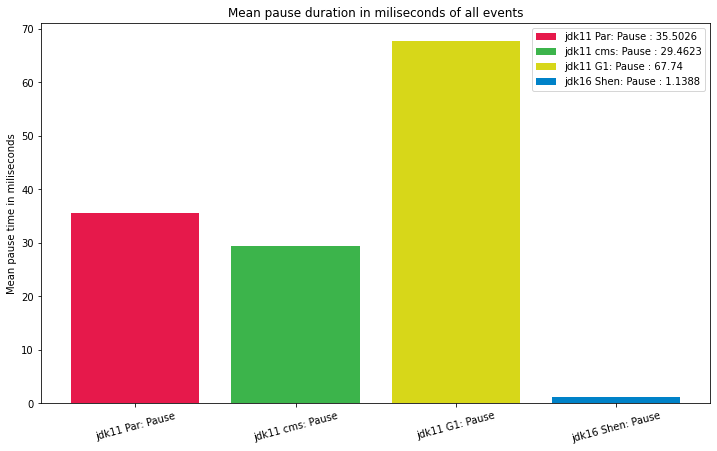

In [182]:
from src.graphing.plotting import plot_bar_avg

graph = plot_bar_avg(gc_event_dataframes, group_by = "EventType", filter_by = pauses_only, labels = labels)

_ = graph.set_title("Mean pause duration in miliseconds of all events")
_ = graph.set_ylabel("Mean pause time in miliseconds")
_ = plt.xticks(rotation = 15)

## Heap allocation used before & after GC

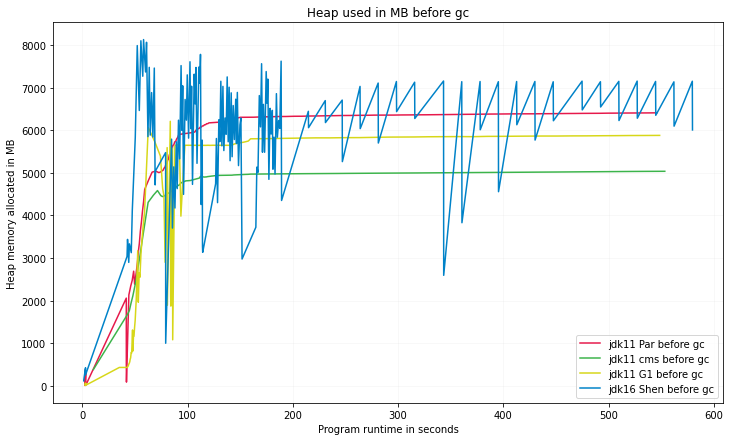

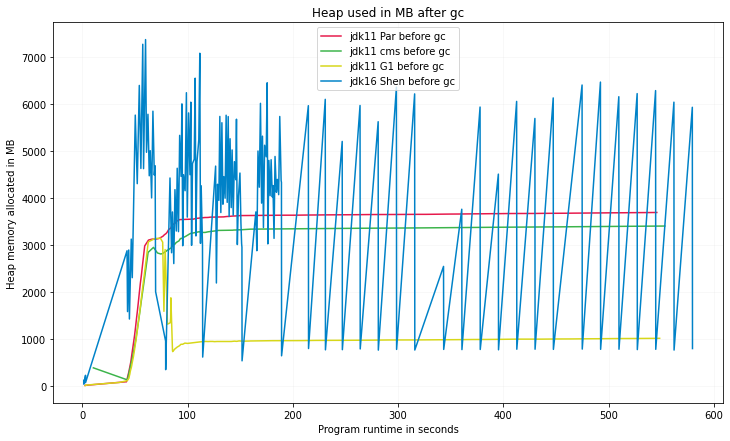

In [183]:
from src.graphing.plotting import plot_scatter, plot_line

for df in gc_event_dataframes:
    if "TimeFromStart_seconds" in df:
        df.sort_values(by="TimeFromStart_seconds", axis=0,inplace=True)

def heap_before_gc(row):
    if "HeapBeforeGC" in row:
        if row["HeapBeforeGC"]:
            return True
    return False
labels_before_gc = [label + " before gc" for label in labels]

def heap_after_gc(row):
    if "HeapAfterGC" in row:
        if row["HeapAfterGC"]:
            return True
    return False
labels_after_gc = [label + " before gc" for label in labels]


plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_before_gc, # Confirm that this column has data for every row
            labels = labels_before_gc,
            column = "HeapBeforeGC")


_ = plot.set_title("Heap used in MB before gc")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")
plot.grid(alpha = 0.1)
#----
plot = plot_line(gc_event_dataframes,
            group_by = None, 
            filter_by = heap_after_gc,
            labels = labels_after_gc,
            column = "HeapAfterGC")
            
_ = plot.set_title("Heap used in MB after gc")
_ = plot.set_ylabel("Heap memory allocated in MB")
_ = plot.set_xlabel("Program runtime in seconds")


plot.grid(alpha = 0.1)

## MB reclaimed during GC during runtime

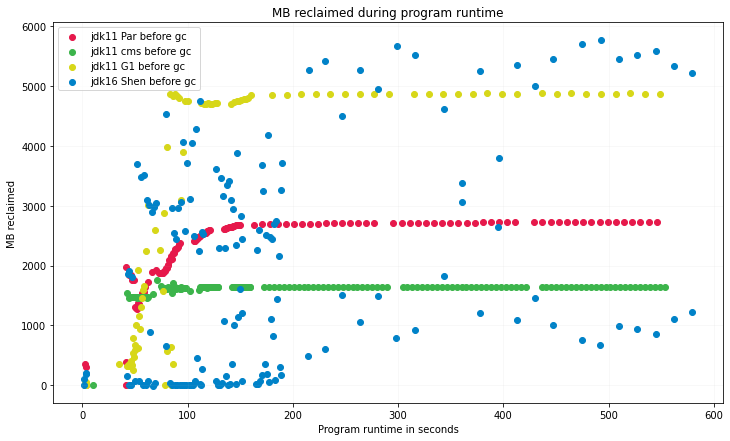

In [184]:
from src.graphing.plotting import plot_reclaimed_bytes

def gc_values_present(row):
    if "HeapBeforeGC" in row and "HeapAfterGC":
        if row["HeapBeforeGC"] != None and row["HeapAfterGC"] != None:
            return True
    return False

plot = plot_reclaimed_bytes(gc_event_dataframes, filter_by = gc_values_present, labels = labels)
_ = plot.set_title("MB reclaimed during program runtime")
_ = plot.set_ylabel("MB reclaimed")
_ = plot.set_xlabel("Program runtime in seconds")

plot.grid(alpha = 0.1)


## Heatmaps for each log

In [185]:
from src.graphing.plotting import plot_heatmaps

number_x_intervals  = 10
number_y_intervals  = 20
duration_x_interval = 50 # seconds
duration_y_interval = 10 # miliseconds
dimensions = [number_x_intervals,
              number_y_intervals,
              duration_x_interval,
              duration_y_interval]

frequency_ticks = False
plot_heatmaps(gc_event_dataframes,
               dimensions, 
               filter_by = pauses_only, 
               labels=labels,
               frequency_ticks = frequency_ticks)

## Frequency of pauses histogram

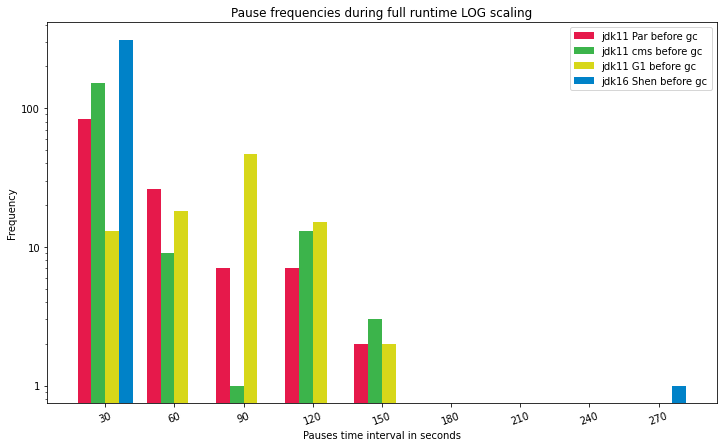

In [244]:
from src.graphing.plotting import plot_frequency_intervals

# All intervals are in seconds
plot = plot_frequency_intervals(gc_event_dataframes,
                         filter_by = pauses_only,
                         interval_duration = 30,                          
                         labels = labels)
                         
_ = plt.xticks(rotation = 20)
plot.set_xlabel("Pauses time interval in seconds")
plot.set_ylabel("Frequency")
plot.set_title("Pause frequencies during full runtime LOG scaling")
plot.set_yscale("log")

plot.yaxis.set_major_formatter(ScalarFormatter())


Percentiles plotted:  [99.9, 90, 50]


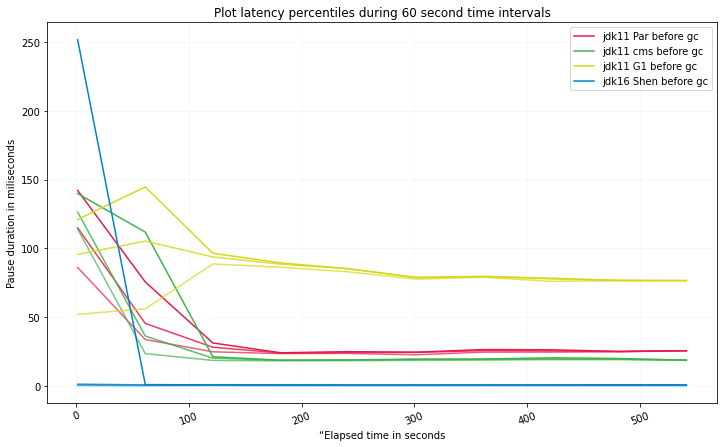

In [240]:
from src.graphing.plotting import plot_percentile_intervals
interval_duration = 60 
percentiles = [99.9, 90, 50]
plot = plot_percentile_intervals(gc_event_dataframes, 
                                filter_by = pauses_only,
                                interval_duration = interval_duration ,
                                labels = labels,
                                percentiles = percentiles,
                                line_graph = True)
plot.set_ylabel("Pause duration in miliseconds")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Plot latency percentiles during "+ str(interval_duration) + " second time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)
print("Percentiles plotted: ", percentiles)

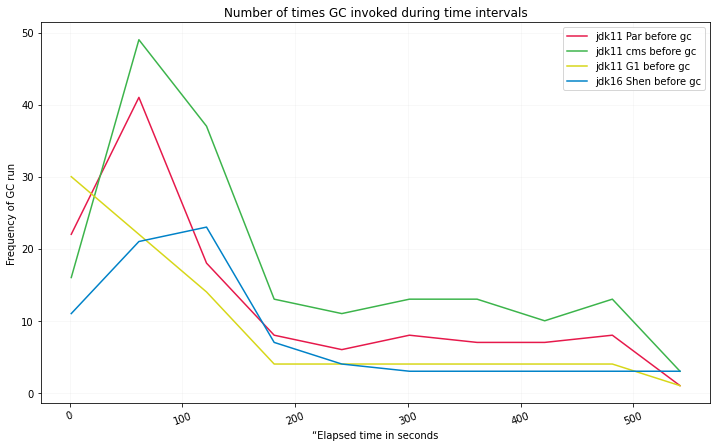

In [238]:
from src.graphing.plotting import plot_frequency_of_gc_intervals

plot = plot_frequency_of_gc_intervals(gc_event_dataframes, 
                                      filter_by = pauses_only, 
                                      interval_duration = 60 , 
                                      labels = labels)
plot.set_ylabel("Frequency of GC run")
plot.set_xlabel("“Elapsed time in seconds")
plot.set_title("Number of times GC invoked during time intervals")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)


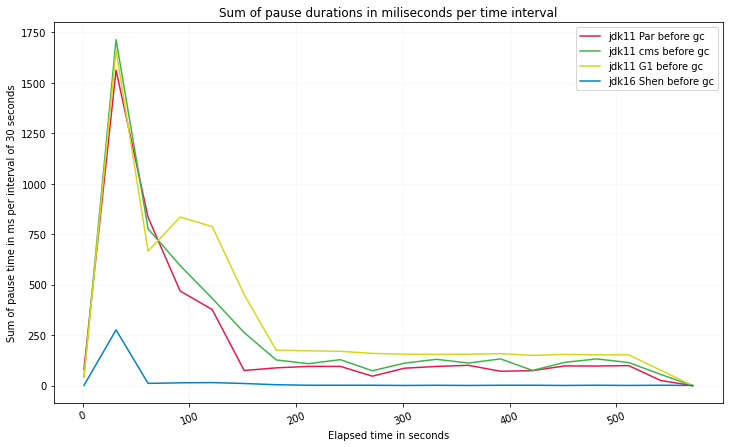

In [237]:
from src.graphing.plotting import plot_sum_pause_intervals

interval_duration = 30
plot = plot_sum_pause_intervals(gc_event_dataframes,
                                filter_by = pauses_only,
                                interval_duration = interval_duration, 
                                labels = labels,
                                line_graph = True )
_ = plot.set_title("Sum of pause durations in miliseconds per time interval")
plot.set_ylabel("Sum of pause time in ms per interval of " + str(interval_duration) + " seconds", )
plot.set_xlabel("Elapsed time in seconds")
plot.grid(alpha = 0.1)
_ = plt.xticks(rotation = 20)

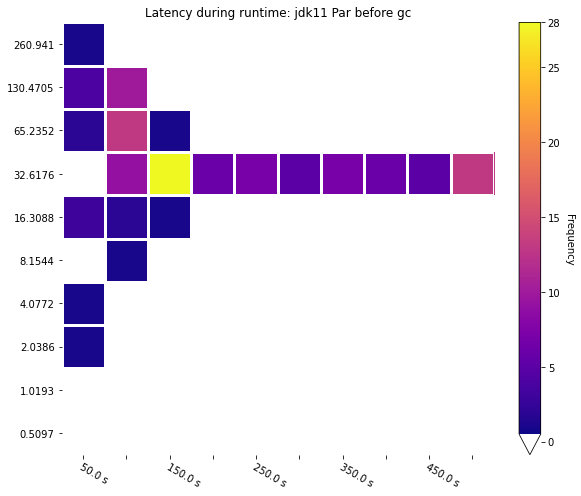

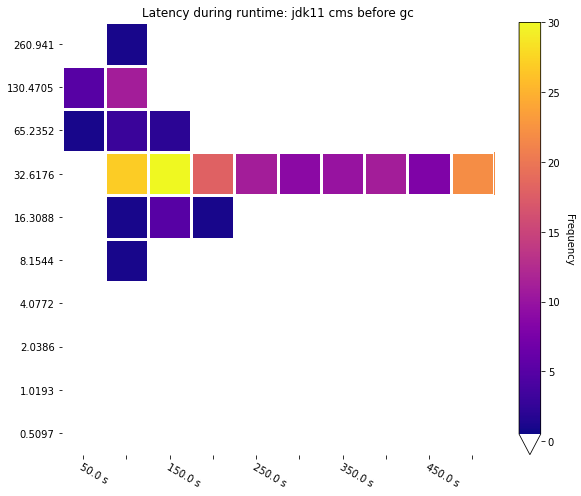

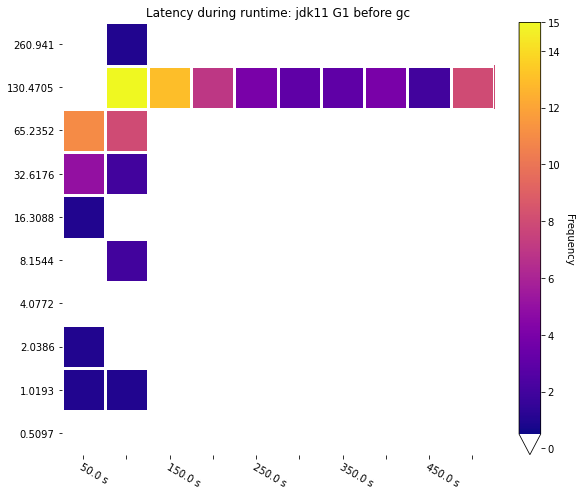

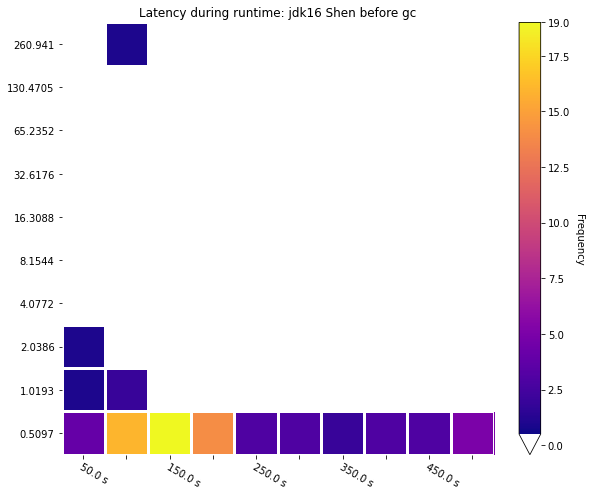

In [226]:
from src.graphing.plotting import plot_heatmaps_logarithmic
dimensions = [10, 10, 50, 2]
# [ x bucket count, y bucket count, x timestamp count, base]
frequency_ticks = False
plot_heatmaps_logarithmic(gc_event_dataframes,dimensions, filter_by = pauses_only, labels=labels, frequency_ticks = frequency_ticks)


4


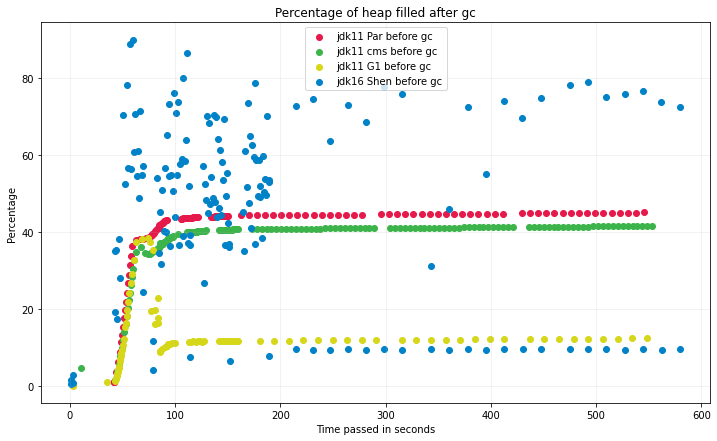

In [196]:
from src.graphing.plotting import plot_percentages
print(len(gc_event_dataframes))
labels_after_gc = [label + " before gc" for label in labels]
plot = plot_percentages(gc_event_dataframes, 
                        filter_by = heap_before_gc,
                        labels = labels_before_gc,
                        max_percentage_values = [8 * 1024, 8 * 1024,8 * 1024, 8 * 1024], 
                        column = "HeapAfterGC",
                        line_graph = False)
plot.set_title("Percentage of heap filled after gc")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("Percentage")
plot.grid(alpha = 0.2)



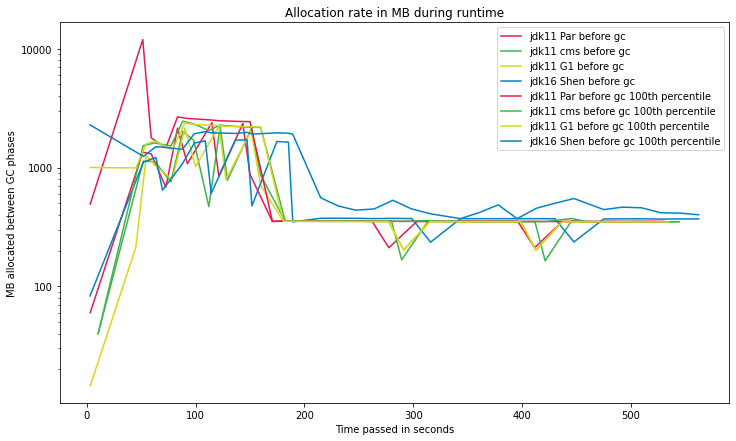

In [225]:
from src.graphing.allocation_rate import allocation_rate
def diff_in_entries_filter(row):
    if "HeapBeforeGC" in row and "HeapAfterGC" in row:
        if row["HeapBeforeGC"] and row["HeapAfterGC"]:
            return True
    return False

interval_seconds = 10
percentile = 100

plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_seconds= interval_seconds,
                             labels = labels,
                             line_graph=True)
plot = allocation_rate(gc_event_dataframes,
                             filter_by = diff_in_entries_filter,
                             interval_seconds= interval_seconds,
                             labels = [label +" " +str(percentile) + "th percentile" for label in labels],
                             percentile = percentile,
                             plot = plot,
                             line_graph=True)                           
plot.set_title("Allocation rate in MB during runtime")
plot.set_xlabel("Time passed in seconds")
plot.set_ylabel("MB allocated between GC phases")
plot.set_yscale("log") 
plot.yaxis.set_major_formatter(ScalarFormatter())